## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 15 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.7]
redice_lr_patient = [10,15,20]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0831 11:14:57.578347  1720 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 11:14:57.580348  1720 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 11:14:57.583348  1720 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 11:14:57.688354  1720 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 10


W0831 11:14:57.941368  1720 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 11:14:57.950369  1720 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0831 11:14:58.035373  1720 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 5s 110us/step - loss: 2.2348 - acc: 0.2652 - val_loss: 2.0217 - val_acc: 0.3393
Epoch 2/15
50000/50000 [==============================] - 5s 96us/step - loss: 1.7510 - acc: 0.3913 - val_loss: 1.8220 - val_acc: 0.3711
Epoch 3/15
50000/50000 [==============================] - 5s 95us/step - loss: 1.6263 - acc: 0.4324 - val_loss: 1.6966 - val_acc: 0.4061
Epoch 4/15
50000/50000 [==============================] - 5s 95us/step - loss: 1.5549 - acc: 0.4601 - val_loss: 1.6370 - val_acc: 0.4214
Epoch 5/15
50000/50000 [==============================] - 5s 95us/step - loss: 1.5009 - acc: 0.4768 - val_loss: 1.6090 - val_acc: 0.4367
Epoch 6/15
50000/50000 [==============================] - 5s 95us/step - loss: 1.4532 - acc: 0.4958 - val_loss: 1.5750 - val_acc: 0.4457
Epoch 7/15
50000/50000 [==============================] - 5s 97us/step - loss: 1.4147 - acc: 0.5080 - val_loss: 1.5562 - val_ac

50000/50000 [==============================] - 6s 124us/step - loss: 1.3669 - acc: 0.5200 - val_loss: 1.5186 - val_acc: 0.4687
Epoch 9/15
50000/50000 [==============================] - 6s 115us/step - loss: 1.3336 - acc: 0.5340 - val_loss: 1.5104 - val_acc: 0.4656
Epoch 10/15
50000/50000 [==============================] - 5s 104us/step - loss: 1.3035 - acc: 0.5457 - val_loss: 1.4910 - val_acc: 0.4732
Epoch 11/15
50000/50000 [==============================] - 5s 104us/step - loss: 1.2734 - acc: 0.5582 - val_loss: 1.4807 - val_acc: 0.4747
Epoch 12/15
50000/50000 [==============================] - 6s 114us/step - loss: 1.2463 - acc: 0.5680 - val_loss: 1.4736 - val_acc: 0.4827
Epoch 13/15
50000/50000 [==============================] - 5s 102us/step - loss: 1.2195 - acc: 0.5771 - val_loss: 1.4671 - val_acc: 0.4815
Epoch 14/15
50000/50000 [==============================] - 5s 105us/step - loss: 1.1941 - acc: 0.5864 - val_loss: 1.4658 - val_acc: 0.4868
Epoch 15/15
50000/50000 [===============

50000/50000 [==============================] - 6s 120us/step - loss: 1.1835 - acc: 0.5927 - val_loss: 1.4873 - val_acc: 0.4818
Numbers of exp: 7, reduce_factor: 0.70, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense) 

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 11s 211us/step - loss: 1.7719 - acc: 0.3837 - val_loss: 1.9725 - val_acc: 0.3460
Epoch 2/15
50000/50000 [==============================] - 8s 162us/step - loss: 1.4885 - acc: 0.4762 - val_loss: 1.6512 - val_acc: 0.4168
Epoch 3/15
50000/50000 [==============================] - 8s 152us/step - loss: 1.3888 - acc: 0.5120 - val_loss: 2.0434 - val_acc: 0.3166
Epoch 4/15
50000/50000 [==============================] - 7s 149us/step - loss: 1.3064 - acc: 0.5418 - val_loss: 1.9505 - val_acc: 0.3484
Epoch 5/15
50000/50000 [==============================] - 6s 126us/step - loss: 1.2481 - acc: 0.5590 - val_loss: 1.9027 - val_acc: 0.3664
Epoch 6/15
50000/50000 [==============================] - 6s 118us/step - loss: 1.1880 - acc: 0.5825 - val_loss: 1.9704 - val_acc: 0.3606
Epoch 7/15
50000/50000 [==============================] - 6s 121us/step - loss: 1.1401 - acc: 0.6005 - val_loss: 1.9121 -

50000/50000 [==============================] - 6s 112us/step - loss: 1.1483 - acc: 0.6017 - val_loss: 1.5834 - val_acc: 0.4404
Epoch 8/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.1048 - acc: 0.6164 - val_loss: 1.5086 - val_acc: 0.4699
Epoch 9/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.0614 - acc: 0.6340 - val_loss: 1.5394 - val_acc: 0.4608
Epoch 10/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.0180 - acc: 0.6500 - val_loss: 1.4792 - val_acc: 0.4827
Epoch 11/15
50000/50000 [==============================] - 6s 112us/step - loss: 0.9775 - acc: 0.6648 - val_loss: 1.4664 - val_acc: 0.4795
Epoch 12/15
50000/50000 [==============================] - 6s 112us/step - loss: 0.9380 - acc: 0.6795 - val_loss: 1.5551 - val_acc: 0.4693
Epoch 13/15
50000/50000 [==============================] - 6s 112us/step - loss: 0.9046 - acc: 0.6915 - val_loss: 1.5765 - val_acc: 0.4720
Epoch 14/15
50000/50000 [================

50000/50000 [==============================] - 6s 112us/step - loss: 0.8783 - acc: 0.6992 - val_loss: 1.5080 - val_acc: 0.4820
Epoch 15/15
50000/50000 [==============================] - 6s 112us/step - loss: 0.8425 - acc: 0.7138 - val_loss: 1.6860 - val_acc: 0.4355
Numbers of exp: 14, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normaliz

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s 156us/step - loss: 1.7642 - acc: 0.3874 - val_loss: 1.6833 - val_acc: 0.4087
Epoch 2/15
50000/50000 [==============================] - 6s 114us/step - loss: 1.4952 - acc: 0.4733 - val_loss: 1.6332 - val_acc: 0.4178
Epoch 3/15
50000/50000 [==============================] - 6s 113us/step - loss: 1.3969 - acc: 0.5095 - val_loss: 1.5561 - val_acc: 0.4430
Epoch 4/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.3235 - acc: 0.5341 - val_loss: 1.4969 - val_acc: 0.4719
Epoch 5/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.2603 - acc: 0.5596 - val_loss: 1.5306 - val_acc: 0.4598
Epoch 6/15
50000/50000 [==============================] - 6s 113us/step - loss: 1.2092 - acc: 0.5777 - val_loss: 1.5156 - val_acc: 0.4620
Epoch 7/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.1573 - acc: 0.5984 - val_loss: 1.5700 - 

50000/50000 [==============================] - 5s 106us/step - loss: 1.1598 - acc: 0.5906 - val_loss: 2.3030 - val_acc: 0.3163
Epoch 9/15
50000/50000 [==============================] - 5s 106us/step - loss: 1.1185 - acc: 0.6065 - val_loss: 2.5817 - val_acc: 0.2879
Epoch 10/15
50000/50000 [==============================] - 5s 106us/step - loss: 1.0878 - acc: 0.6186 - val_loss: 1.6477 - val_acc: 0.4215
Epoch 11/15
50000/50000 [==============================] - 5s 107us/step - loss: 1.0553 - acc: 0.6287 - val_loss: 1.9405 - val_acc: 0.3756
Epoch 12/15
50000/50000 [==============================] - 5s 107us/step - loss: 1.0160 - acc: 0.6410 - val_loss: 1.7712 - val_acc: 0.3851
Epoch 13/15
50000/50000 [==============================] - 5s 106us/step - loss: 0.9871 - acc: 0.6523 - val_loss: 1.8255 - val_acc: 0.4177
Epoch 14/15
50000/50000 [==============================] - 5s 108us/step - loss: 0.9593 - acc: 0.6616 - val_loss: 1.9241 - val_acc: 0.3837
Epoch 15/15
50000/50000 [===============

50000/50000 [==============================] - 5s 106us/step - loss: 0.9127 - acc: 0.6774 - val_loss: 1.9774 - val_acc: 0.3968
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_64 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_65 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 13s 256us/step - loss: 1.8082 - acc: 0.3744 - val_loss: 2.3982 - val_acc: 0.2764
Epoch 2/15
50000/50000 [==============================] - 8s 169us/step - loss: 1.5399 - acc: 0.4552 - val_loss: 2.1748 - val_acc: 0.3009
Epoch 3/15
50000/50000 [==============================] - 9s 174us/step - loss: 1.4293 - acc: 0.4956 - val_loss: 2.5055 - val_acc: 0.2631
Epoch 4/15
50000/50000 [==============================] - 9s 174us/step - loss: 1.3620 - acc: 0.5216 - val_loss: 2.1790 - val_acc: 0.2844
Epoch 5/15
50000/50000 [==============================] - 9s 175us/step - loss: 1.3047 - acc: 0.5417 - val_loss: 2.5376 - val_acc: 0.2587
Epoch 6/15
50000/50000 [==============================] - 9s 173us/step - loss: 1.2512 - acc: 0.5597 - val_loss: 2.3582 - val_acc: 0.2877
Epoch 7/15
50000/50000 [==============================] - 9s 173us/step - loss: 1.2083 - acc: 0.5754 - val_loss: 2.0524 -

50000/50000 [==============================] - 6s 119us/step - loss: 1.1685 - acc: 0.5879 - val_loss: 1.9136 - val_acc: 0.3643
Epoch 9/15
50000/50000 [==============================] - 6s 119us/step - loss: 1.1245 - acc: 0.6034 - val_loss: 2.2750 - val_acc: 0.3070
Epoch 10/15
50000/50000 [==============================] - 6s 119us/step - loss: 1.0923 - acc: 0.6137 - val_loss: 2.0868 - val_acc: 0.3572
Epoch 11/15
50000/50000 [==============================] - 7s 134us/step - loss: 1.0549 - acc: 0.6273 - val_loss: 1.8808 - val_acc: 0.3640
Epoch 12/15
50000/50000 [==============================] - 9s 182us/step - loss: 1.0240 - acc: 0.6399 - val_loss: 2.1634 - val_acc: 0.3235
Epoch 13/15
50000/50000 [==============================] - 10s 190us/step - loss: 0.9848 - acc: 0.6551 - val_loss: 2.2558 - val_acc: 0.3581
Epoch 14/15
50000/50000 [==============================] - 9s 185us/step - loss: 0.9579 - acc: 0.6621 - val_loss: 2.0406 - val_acc: 0.3609
Epoch 15/15
50000/50000 [==============

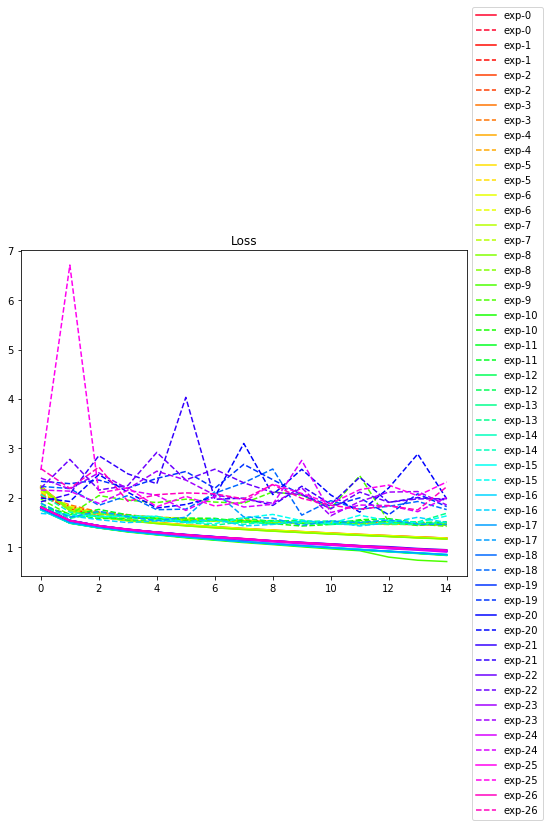

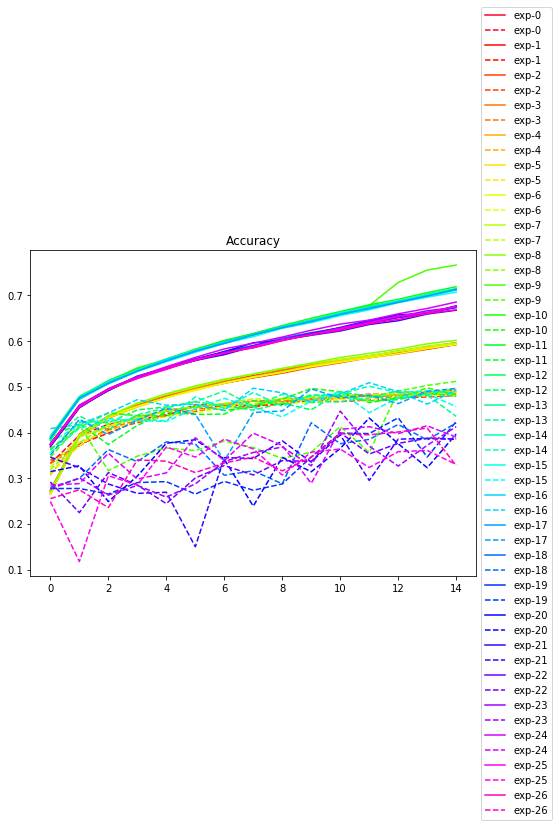

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()